In [63]:
import numpy as np
import cv2
import os
from pathlib import Path

def create_ellipse_image(size=(256, 256), short_axis_min=100, long_axis_min=250, ratio=3):
    """
    Create a synthetic ellipse image.
    Args:
        size: Size of the output image (height, width).
        short_axis_min: Minimum length of the short axis.
        long_axis_min: Minimum length of the long axis.
        ratio: Maximum ratio of long axis to short axis.
    Returns:
        An image with a drawn ellipse.
    """
    # Ensure that the minimum lengths are valid for the given size
    if short_axis_min >= size[0] or long_axis_min >= size[1]:
        raise ValueError("Minimum axis lengths must be less than the image size.")

    # Randomly generate axes lengths
    short_axis = np.random.randint(short_axis_min, size[1])
    long_axis = np.random.randint(long_axis_min, size[0])

    # Ensure the ratio constraint
    if long_axis / short_axis > ratio:
        long_axis = int(short_axis * ratio)

    # Create a blank image
    image = np.zeros(size, dtype=np.uint8)

    # Calculate the center of the ellipse
    center = (size[1] // 2, size[0] // 2)

    # Generate random angle between 0 and 180 degrees
    angle = np.random.randint(0, 180)

    # Draw the ellipse with random rotation
    cv2.ellipse(image, center, (long_axis // 2, short_axis // 2), angle, 0, 360, 255, -1)

    return image

def add_holes(image, max_holes=10, max_diameter=30):
    """
    Add random circular holes to the image.
    Args:
        image: Input image (grayscale).
        max_holes: Maximum number of holes to add.
        max_diameter: Maximum diameter of holes in pixels.
    Returns:
        Distorted image with holes.
    """
    height, width = image.shape
    distorted = image.copy()

    # Random number of holes (1 to max_holes)
    n_holes = np.random.randint(1, max_holes + 1)

    for _ in range(n_holes):
        # Random diameter (5 to max_diameter)
        diameter = np.random.randint(5, max_diameter + 1)
        radius = diameter // 2

        # Random position (ensuring hole is within the image)
        center_y = np.random.randint(radius, height - radius)
        center_x = np.random.randint(radius, width - radius)

        # Create circular mask
        y, x = np.ogrid[-radius:radius + 1, -radius:radius + 1]
        mask = x * x + y * y <= radius * radius

        # Apply the hole (set pixels to 0)
        y_min, y_max = max(0, center_y - radius), min(height, center_y + radius + 1)
        x_min, x_max = max(0, center_x - radius), min(width, center_x + radius + 1)

        mask_height = y_max - y_min
        mask_width = x_max - x_min
        mask = mask[:mask_height, :mask_width]

        distorted[y_min:y_max, x_min:x_max][mask] = 0

    return distorted

def generate_training_set(output_dir, num_images=100):
    # Create or clean output directories
    clean_dir = os.path.join(output_dir, 'clean')
    noisy_dir = os.path.join(output_dir, 'noisy')
    os.makedirs(clean_dir, exist_ok=True)
    os.makedirs(noisy_dir, exist_ok=True)

    # Clean directories
    for dir_path in [clean_dir, noisy_dir]:
        for file in Path(dir_path).glob('*'):
            try:
                file.unlink()
            except Exception as e:
                print(f"Error removing {file}: {e}")

    slice_count = 0

    for slice_idx in range(num_images):
        try:
            # Create a clean ellipse image
            clean_img = create_ellipse_image()

            # Create and normalize noisy version
            noisy_img = add_holes(clean_img)

            # Save both versions
            clean_path = os.path.join(clean_dir, f'slice_{slice_idx:04d}.png')
            noisy_path = os.path.join(noisy_dir, f'slice_{slice_idx:04d}.png')

            cv2.imwrite(clean_path, clean_img)
            cv2.imwrite(noisy_path, noisy_img)
            slice_count += 1

        except Exception as e:
            print(f"Error saving slice {slice_idx}: {e}")
            continue

    print(f"Saved {slice_count} pairs of clean and noisy images to {output_dir}")
    return slice_count


In [64]:
output_dir = "trainingData"
output_test_dir = "testData"
num_images = 300 
num_test_images = 60
generate_training_set(output_dir, num_images)
generate_training_set(output_test_dir, num_test_images)

Saved 300 pairs of clean and noisy images to trainingData
Saved 60 pairs of clean and noisy images to testData


60

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Decoder layers
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # Decoder with skip connections
        d1 = self.dec1(e3)
        d1 = torch.cat([d1, e2], dim=1)  # Skip connection
        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e1], dim=1)  # Skip connection
        d3 = self.dec3(d2)
        return d3

class DenoisingDataset(Dataset):
    def __init__(self, clean_dir, noisy_dir):
        """
        Args:
            clean_dir: Directory with original images
            noisy_dir: Directory with noisy images
        """
        self.clean_dir = Path(clean_dir)
        self.noisy_dir = Path(noisy_dir)
        self.image_files = sorted(list(self.clean_dir.glob('*.png')))  # Get all PNG files
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Get clean image path and construct corresponding noisy image path
        clean_path = self.image_files[idx]
        noisy_path = self.noisy_dir / clean_path.name
        
        # Load images
        clean_img = cv2.imread(str(clean_path), cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.imread(str(noisy_path), cv2.IMREAD_GRAYSCALE)
        
        # Normalize to [0,1]
        clean_img = clean_img.astype(np.float32) / 255.0
        noisy_img = noisy_img.astype(np.float32) / 255.0
        
        # Add channel dimension
        clean_img = np.expand_dims(clean_img, axis=0)
        noisy_img = np.expand_dims(noisy_img, axis=0)
        
        return torch.FloatTensor(noisy_img), torch.FloatTensor(clean_img)

def train_autoencoder(clean_dir, noisy_dir, num_epochs=100, batch_size=32, use_existing_model=False, validation_split=0.2):
    # Try to load existing model
    if use_existing_model:
        try:
            model = torch.load('model.pth')
            print("Loaded existing model")
        except (FileNotFoundError, IOError):
            print("No existing model found, training new model")
            model = DenoisingAutoencoder()
    else:
        model = DenoisingAutoencoder()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create dataset and dataloader
    dataset = DenoisingDataset(clean_dir, noisy_dir)
    dataset_size = len(dataset)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_idx, (noisy, clean) in enumerate(train_loader):
            noisy, clean = noisy.to(device), clean.to(device)
            
            output = model(noisy)
            loss = criterion(output, clean)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}')
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                output = model(noisy)
                val_loss = criterion(output, clean)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.6f}, '
              f'Val Loss: {avg_val_loss:.6f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model, 'best_model.pth')
            print(f'New best model saved at epoch {epoch+1}')
        
        # Save checkpoint periodically
        if (epoch + 1) % 10 == 0:
            os.makedirs('model_checkpoints', exist_ok=True)
            torch.save(model, f'model_checkpoints/model_checkpoint_{epoch+1}.pth')
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses


# Function to test the model on a single image
def denoise_image(model, image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=(0, 1))  # Add batch and channel dimensions
    img_tensor = torch.FloatTensor(img).to(device)
    
    with torch.no_grad():
        denoised = model(img_tensor)
    
    # Convert back to image
    denoised = denoised.cpu().numpy()[0, 0]
    denoised = (denoised * 255).astype(np.uint8)
    
    return denoised


Epoch [1/120], Train Loss: 0.108543, Val Loss: 0.135437
New best model saved at epoch 1
Epoch [2/120], Train Loss: 0.033745, Val Loss: 0.045917
New best model saved at epoch 2
Epoch [3/120], Train Loss: 0.024322, Val Loss: 0.025572
New best model saved at epoch 3
Epoch [4/120], Train Loss: 0.020229, Val Loss: 0.020148
New best model saved at epoch 4
Epoch [5/120], Train Loss: 0.017914, Val Loss: 0.017894
New best model saved at epoch 5
Epoch [6/120], Train Loss: 0.016612, Val Loss: 0.016758
New best model saved at epoch 6
Epoch [7/120], Train Loss: 0.015878, Val Loss: 0.016131
New best model saved at epoch 7
Epoch [8/120], Train Loss: 0.015331, Val Loss: 0.015546
New best model saved at epoch 8
Epoch [9/120], Train Loss: 0.014807, Val Loss: 0.014963
New best model saved at epoch 9
Epoch [10/120], Train Loss: 0.014074, Val Loss: 0.014245
New best model saved at epoch 10
Epoch [11/120], Train Loss: 0.013155, Val Loss: 0.013582
New best model saved at epoch 11
Epoch [12/120], Train Loss: 

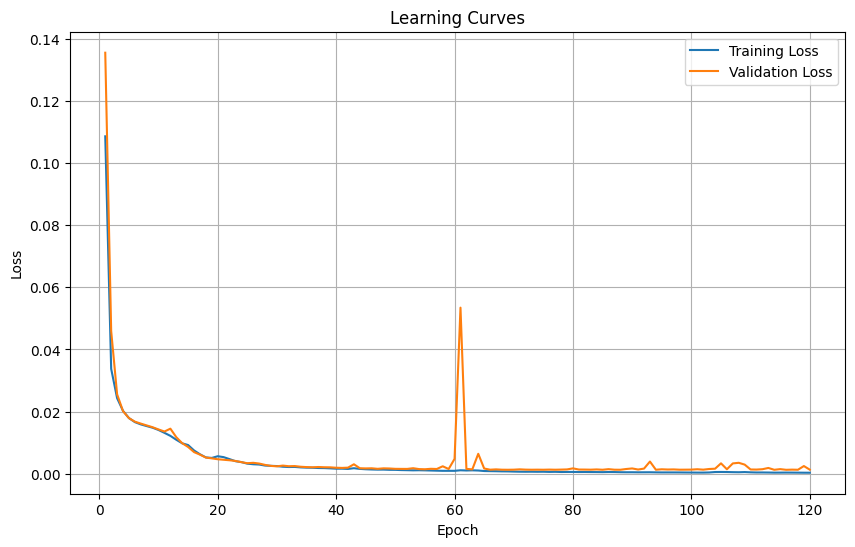

In [66]:
num_epochs = 120
clean_dir = "trainingData/clean"
noisy_dir = "trainingData/noisy"
model, _, _ = train_autoencoder(clean_dir, noisy_dir, num_epochs=num_epochs, batch_size=32, use_existing_model=False)


/tmp/ipykernel_44611/3310325970.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pth')


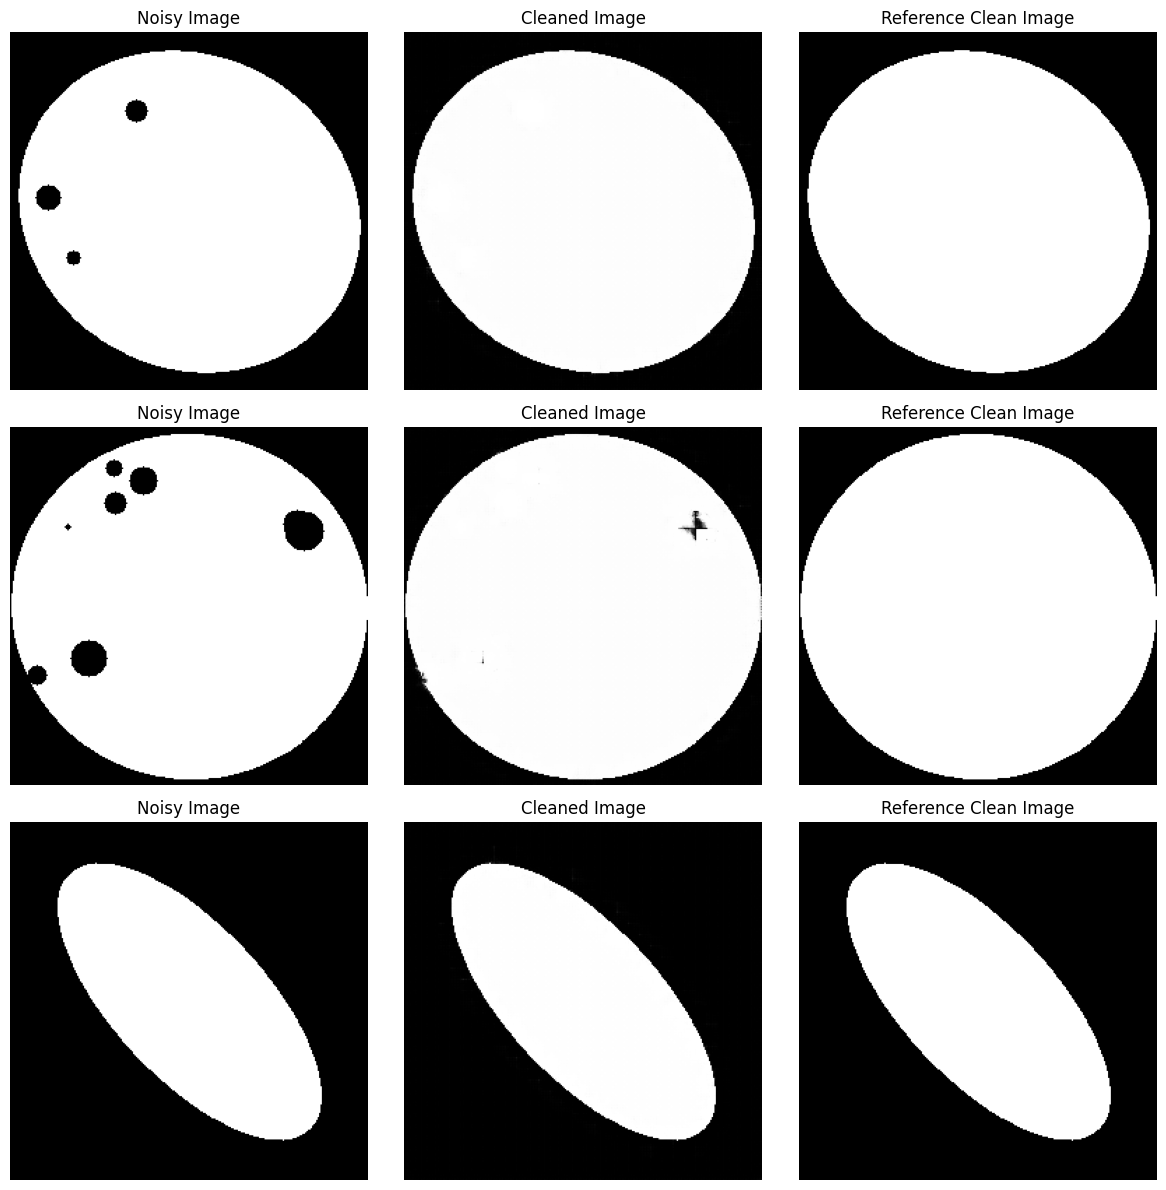

In [68]:
import matplotlib.pyplot as plt
import random
import os

model = torch.load('best_model.pth')

# Get list of all slice files and pick 3 random ones
slice_files = os.listdir('testData/clean')
random_slices = random.sample(slice_files, 3)

# Create figure with 3 rows (one for each slice) and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, slice_file in enumerate(random_slices):
    ref_path = os.path.join('testData/clean', slice_file)
    noisy_path = os.path.join('testData/noisy', slice_file)
    
    cleaned_img = denoise_image(model, noisy_path)
    ref_img = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
    noisy_img = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
    
    axes[i,0].imshow(noisy_img, 'gray')
    axes[i,0].axis('off')
    axes[i,0].set_title("Noisy Image")
    
    axes[i,1].imshow(cleaned_img, 'gray')
    axes[i,1].axis('off')
    axes[i,1].set_title("Cleaned Image")
    
    axes[i,2].imshow(ref_img, 'gray')
    axes[i,2].axis('off')
    axes[i,2].set_title("Reference Clean Image")

plt.tight_layout()